In [2]:
import torch.nn as nn
import torch.nn.functional as F
import math
from torchsummary import summary


def conv3x3(inchannel, outchannel, stride=1):
    "3x3 convoulution with padding"
    return nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False)
# 残差块
class ResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, inchannel, outchannel, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(inchannel, outchannel, stride)
        self.bn1 = nn.BatchNorm2d(outchannel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(outchannel, outchannel)
        self.bn2 = nn.BatchNorm2d(outchannel)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # 把shortcut那的channel的维度统一
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        self.inchannel = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512*block.expansion, num_classes)

       
                
    def _make_layer(self, block, outchannel, blocks, stride=1):
        # downsample主要用来处理H(x)=F(x)+x中F(x)和x的channel维度不匹配的问题
        downsample = None
        # self.inchannel为上个box_block的输出channel， outchannel为当前box_block块的输入channel
        if stride != 1 or self.inchannel != outchannel*block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inchannel, outchannel*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel*block.expansion),
            )
        
        layers = []
        layers.append(block(self.inchannel, outchannel, stride, downsample))
        self.inchannel = outchannel*block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inchannel, outchannel))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
def resnet18():
    #[2, 2, 2, 2]和结构图[]x2是对应的
    model = ResNet(ResidualBlock, [2, 2, 2, 2])
    return model

#model = resnet18()
#print(model)
#print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")
#model = model.to('cuda')
#summary(model, input_size=(3, 32, 32), batch_size=-1, device='cuda')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter



# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



# 超参数设置
EPOCH = 30  # 遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
BATCH_SIZE = 64  # 批处理尺寸(batch_size)
LR = 0.001  # 学习率

# print("开始加载CIFAR10数据集!")
# 准备数据集并预处理
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # R,G,B每层的归一化用到的均值和方差
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 训练数据集
trainset = torchvision.datasets.CIFAR10(root='../input/cifar10', train=True, transform=transform_train, download=True)  
 # 生成一个个batch进行批训练，组成batch的时候顺序打乱取，
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2) 

# 测试训练集
testset = torchvision.datasets.CIFAR10(root='../input/cifar10', train=False, transform=transform_test, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
# Cifar-10的标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("CIFAR10数据集加载完毕!")

print("开始ResNet网络模型初始化!")
# 模型定义-ResNet
model = resnet18().to(device)

# 定义损失函数和优化方式
loss_fn = nn.CrossEntropyLoss()  # 损失函数为交叉熵，多用于多分类问题
loss_fn = loss_fn.to(device)
# 优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
optimizer = optim.SGD(model.parameters(),lr=LR, momentum=0.9, weight_decay=5e-4)  

# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0
# 记录训练集和测试集的正确率，形成列表
total_test_acc_list = []
total_train_acc_list = []

# 添加tensorboard画图可视化
writer = SummaryWriter("../resnet18/logs_train")

print("ResNet网络模型初始化完毕!")
# 训练
if __name__ == "__main__":
    best_acc = 80  # 2 初始化best test accuracy
    best_epoch = 0
    # 有需要可以打开，接着上次训练好的权重训练
    #print("加载模型...")
    #with open("pth/resnet18_12.pth",'rb') as f:
    #     resnet18.load_state_dict(torch.load(f))
    # print("加载完毕!")
    print("开始训练! Resnet-18! 冲!")  # 定义遍历数据集的次数

    for epoch in range(pre_epoch, EPOCH):
        model.train()
        print(f'--------第{epoch + 1}轮训练开始---------')
        total_train_loss = 0.0
        correct = 0.0
        total = 0.0
        for data in tqdm(trainloader):
            # print("-------",i)
            # 准备数据
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            #梯度清零
            optimizer.zero_grad()

            # forward + backward
            # 前向传播获取网络输出信息，做损失函数的输出计算，后向传播获取梯度信息，根据学习策略优化学习
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # 每训练100个batch打印一次loss和准确率
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            total_train_step += 1
            correct += predicted.eq(labels.data).cpu().sum()
    
            writer.add_scalar("train_loss", loss.item(), total_train_step)
        train_accurary = 100 * correct / total
        print(f'训练集正确率为:{train_accurary}')
        total_train_acc_list.append(train_accurary)


        # 每训练完一个epoch测试一下准确率
        print("开始测试!")
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            total_test_loss=0
            for data in tqdm(testloader):
                
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                total_test_loss += loss.item()
                # 取得分最高的那个类 (outputs.data的索引号)
                _, predicted = torch.max(outputs.data, 1)
                # labels是一个尺寸为 的张量[N, 1]，其中N等于批次中的样本数。
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                # result = torch.floor_divide(correct, total)
            # print('测试分类准确率为：%.3f%%' % (100 * result))
            acc = 100 * correct / total
            print(f"测试集上的loss：{total_test_loss}")
            print(f'测试分类准确率为：{acc}')
           
            # 将每次测试结果实时写入acc.txt文件中
            print('Saving model......')
            torch.save(model.state_dict(), f'../resnet18/epoch/resnet18_{epoch + 1}.pth')
            writer.add_scalar("test_loss", total_test_loss, total_test_step)
            total_test_step = total_test_step + 1
            total_test_acc_list.append(acc)
            # 记录最佳测试分类准确率并写入best_acc.txt文件中
            if acc > best_acc:
                f3 = open("../resnet18/best_acc.txt", "w")
                f3.write(f"训练轮次为{epoch + 1}时,准确率最高!准确率为{acc}")
                f3.close()
                best_acc = acc
    print("训练结束!")

for i in range(len(total_test_acc_list)):
    with open('../resnet18/resnet18_acc.txt', 'a') as f:
        f.write('%d %.3f %.3f\n' % (i+1,total_train_acc_list[i],total_test_acc_list[i]))
#     with open('skip18_train_accura/te_records_k.txt', 'a') as f:
#         f.write('%d %.3f\n' % (i+1,total_train_accuracy_list[i]))
torch.save(model.state_dict(),"../resnet18/resnet18_acc_0.001_30_64.pkl")



Files already downloaded and verified
Files already downloaded and verified
cuda


100%|██████████| 79/79 [00:07<00:00, 10.80it/s]


Accuracy of airplane : 83.700 %
Accuracy of automobile : 90.600 %
Accuracy of  bird : 69.900 %
Accuracy of   cat : 60.100 %
Accuracy of  deer : 78.000 %
Accuracy of   dog : 72.400 %
Accuracy of  frog : 88.100 %
Accuracy of horse : 85.200 %
Accuracy of  ship : 91.500 %
Accuracy of truck : 90.100 %
[[837   9  23  13  10   7   7   8  55  31]
 [ 12 906   1   6   1   4   2   0  12  56]
 [ 68   1 699  43  67  42  47  21   6   6]
 [ 23   9  62 601  47 133  66  32  18   9]
 [ 15   1  47  43 780  19  46  37   9   3]
 [ 15   5  38 110  38 724  22  37   5   6]
 [  5   1  34  32  21  12 881   5   7   2]
 [ 16   1  17  19  39  36   7 852   5   8]
 [ 35  15   5   4   1   1   9   2 915  13]
 [ 24  36   4   3   2   2   4   5  19 901]]


<Figure size 640x480 with 0 Axes>

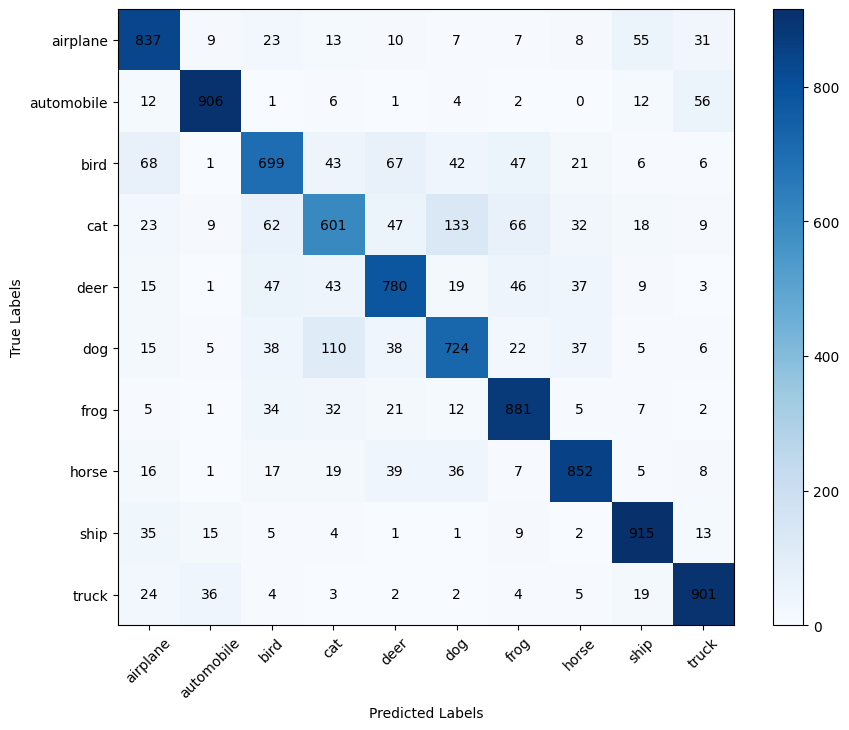

In [3]:
# 使用cifar10数据集，跳跃网络

from numpy import log2
import torch
import torch.nn.functional as F
from torch.nn.modules import flatten
from torch.nn.modules.flatten import Flatten
from torch.nn.modules.pooling import MaxPool2d
import torchvision
from torch.utils.data import DataLoader, dataloader
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import os
import torch.optim as optim
from sklearn.metrics import confusion_matrix

seed_n = 121
print('seed is ' + str(seed_n))
g = torch.Generator()
g.manual_seed(seed_n)
random.seed(seed_n)
np.random.seed(seed_n)
torch.manual_seed(seed_n)
torch.cuda.manual_seed(seed_n)
torch.cuda.manual_seed_all(seed_n)
            # torch.backends.cudnn.deterministic=True
            # torch.backends.cudnn.benchmark = False
            # torch.backends.cudnn.enabled = False
            # torch.use_deterministic_algorithms(True)
            # os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['PYTHONHASHSEED'] = str(seed_n)  # 为了禁止hash随机化，使得实验可复现。

transform_train = transforms.Compose([
   
    transforms.ToTensor(),
   
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
   transforms.ToTensor(),
  
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root="../input/cifar10",train=True,transform=transform_train,download=True)
test_dataset = torchvision.datasets.CIFAR10(root="../input/cifar10",train=False,transform=transform_test,download=True)



#数据集长度
train_data_size = len(train_dataset)
test_data_size = len(test_dataset)


train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


test_net = resnet18()

test_net.load_state_dict(torch.load("../resnet18/resnet18_acc_0.001_30_64.pkl"))

test_net.to(device)
#创建损失函数
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn.to(device)
#创建优化器
learning_rata = 0.001
#learning_rata = 0.01#或者使用1e-2代替0.01
optimizer = optim.SGD(test_net.parameters(),lr=learning_rata, momentum=0.9, weight_decay=5e-4)


plt.figure()

#训练的次数
total_train_step = 0
#测试次数
total_test_step = 0
total_train_accuracy = 0
# Decey_x = 0.5
total_train_accuracy_list = []
total_test_accuracy_list = []

total_accuracy = 0
#测试步骤
test_net.eval()
total_test_loss = 0
total_test_step = 0
# 测试模型
correct = [0] * 10
total = [0] * 10
y_pred = []
y_true = []
with torch.no_grad():
    for data in tqdm(test_dataloader):
        images, labels = data
        images = images.to(device)
        # images = images.view(-1,3,32,32)
        labels = labels.to(device)

        outputs = test_net(images)

        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())
        for i in range(len(labels)):
            label = labels[i]
            total[label] += 1
            if predicted[i] == label:
                correct[label] += 1

# 输出每个类别的准确率
for i in range(10):
    print('Accuracy of %5s : %.3f %%' % (
        test_dataset.classes[i], 100 * correct[i] / total[i]))


# 将预测结果转换为标签
y_pred_labels = np.array(y_pred)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred_labels)

print(cm)



# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# 添加数值
for i in range(10):
    for j in range(10):
        plt.annotate(str(cm[i][j]), xy=(j, i), horizontalalignment='center', verticalalignment='center')

plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], rotation=45)
plt.yticks(tick_marks, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# plt.show()
plt.savefig('../resnet18/confusion_matrixA.png')
        


In [4]:
from sklearn.metrics import classification_report

# 计算准确率、召回率、精确率和 F1 值
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classification_report(y_true, y_pred_labels, target_names=target_names,digits=3))

              precision    recall  f1-score   support

    airplane      0.797     0.837     0.817      1000
  automobile      0.921     0.906     0.913      1000
        bird      0.752     0.699     0.724      1000
         cat      0.688     0.601     0.641      1000
        deer      0.775     0.780     0.778      1000
         dog      0.739     0.724     0.731      1000
        frog      0.808     0.881     0.843      1000
       horse      0.853     0.852     0.852      1000
        ship      0.871     0.915     0.892      1000
       truck      0.871     0.901     0.886      1000

    accuracy                          0.810     10000
   macro avg      0.807     0.810     0.808     10000
weighted avg      0.807     0.810     0.808     10000

